In [1]:
import pandas as pd 
import numpy as np
import glob 
import os 
import matplotlib.pyplot as plt 
from matplotlib.patches import FancyBboxPatch 
from textwrap import fill 

path = r"C:\Users\Emre\Documents\my codes\data analysis\Uzduotys\eso_dataset_1975" 
all_files = glob.glob(os.path.join(path , "*.csv")) # Get all filenames

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True) # Read and combine all data in a dataframe
df = df.drop(df.columns[[0, 2, 6]], axis=1) # Drop unused columns 

# Convert to datetime
df['PL_T'] = pd.to_datetime(df['PL_T'])
df['Metai'] = df['PL_T'].dt.year
df['Mėnuo'] = df['PL_T'].dt.month
df['Data'] = df['PL_T'].dt.date


## 1-A

In [2]:
data_771822 = df.loc[df["OBJ_NUMERIS"] == 771822] # Filter obj 771822
sum_771822 = data_771822["P+"].sum() # Sum all usage
print(f"{sum_771822:.4f} kWh")

3046.7770 kWh


## 1-B

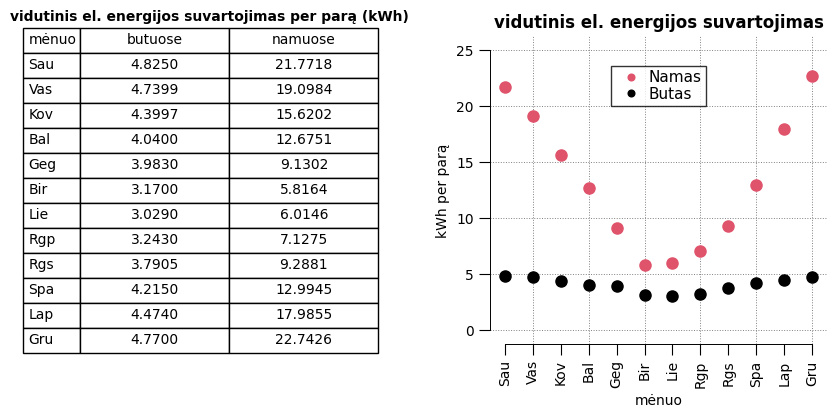

In [3]:
# Calculate daily total consumption for each object
daily_totals = df.groupby(
    ['Data', 'Mėnuo', 'OBJ_NUMERIS', 'OBT_PAVADINIMAS']
    )['P+'].sum().reset_index(name='Dienos_Suvartojimas')

# Separate data for apartments and houses, then calculate median of daily totals for each month
apartment_data = (
    daily_totals[daily_totals["OBT_PAVADINIMAS"] == "Butas"]
    .groupby(['Mėnuo'])['Dienos_Suvartojimas']
    .median()
    .reset_index(name='Vidutinis_Dienos_Suvartojimas')
    )
house_data = (
    daily_totals[daily_totals["OBT_PAVADINIMAS"] == "Namas"]
    .groupby(['Mėnuo'])['Dienos_Suvartojimas']
    .median()
    .reset_index(name='Vidutinis_Dienos_Suvartojimas')
    )

# Combine apartment and house data for comparison
combined_median = pd.merge(apartment_data, house_data, on='Mėnuo', suffixes=('_Butui', '_Namui'))

months = ['Sausis', 'Vasaris', 'Kovas', 'Balandis', 'Gegužė', 'Birželis', 'Liepa', 'Rugpjūtis', 'Rugsėjis', 'Spalis', 'Lapkritis', 'Gruodis']
months_ab = [i[:3] for i in months] # abbreviate all moths
months_ab[7] = "Rgp" # change same month abbreviations
months_ab[8] = "Rgs"

combined_median['Mėnė'] = combined_median['Mėnuo'].apply(lambda x: months_ab[x-1])

# Create main plot and table figure with subplots
fig, (table_fig, plot_ax) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 1.7]})
fig.subplots_adjust(wspace=0.6)  # Adjust spacing between table and plot

# Table data preparation
table_data = combined_median[['Mėnė', 
                              'Vidutinis_Dienos_Suvartojimas_Butui', 
                              'Vidutinis_Dienos_Suvartojimas_Namui']].set_index('Mėnė')
table_data = table_data.map(lambda x: f"{x:.4f}")  # Format each float to four decimal places

row_labels = months

# Create a new row with "Header" values, shifting everything to the right
extra_row = ["butuose", "namuose"]

# Add the new row at the top of the table data
table_data_with_header = pd.DataFrame([extra_row] + table_data.values.tolist(), columns=table_data.columns)

# Update the row labels to include the new "Month" entry
row_labels = ['mėnuo'] + table_data.index.tolist()

# Update column labels to include the extra "Month" column at the top
column_labels_with_extra = ["vidutinis el. energijos suvartojimas per parą (kWh)"]*2

# Create table in the left subplot
table_fig.axis('off')  # Hide the axis for table subplot

table = table_fig.table(
    cellText=table_data_with_header.values,
    rowLabels=row_labels,
    cellLoc='center',
    loc='center'
)

# Add header text above the table without modifying the table structure
table_fig.text(0.4, 1.05, "vidutinis el. energijos suvartojimas per parą (kWh)", ha='center', fontsize=10, weight='bold')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)  # Adjust scale to fit the table
table_fig.axis('off')  # Hide the axis for table subplot

# Plot in the right subplot
x_values = range(1, len(combined_median['Mėnė']) + 1)
plot_ax.plot(x_values, combined_median['Vidutinis_Dienos_Suvartojimas_Namui'], 
             'o', label='Namas', color="#df536b", markersize=8)
plot_ax.plot(x_values, combined_median['Vidutinis_Dienos_Suvartojimas_Butui'], 
             'o', label='Butas', color="black", markersize=8)

# Labeling and customization
plot_ax.set_xlabel('mėnuo')
plot_ax.set_ylabel('kWh per parą')
plot_ax.legend(loc="upper center", edgecolor="black", fancybox=False, 
               borderpad=0.3,fontsize=11, markerscale=0.6, 
               handletextpad=0.1, labelspacing=0.1, bbox_to_anchor=(0.5, 0.93)
               )
plot_ax.set_title('vidutinis el. energijos suvartojimas', fontsize=12, fontweight='bold')

plot_ax.spines['bottom'].set_visible(False)
plot_ax.spines['left'].set_visible(False)
plot_ax.spines['top'].set_visible(False)
plot_ax.spines['right'].set_visible(False)

# Replot x and y axis
plot_ax.plot([1, 12], [0, 0], color='black', lw=0.7,
             transform=plot_ax.get_xaxis_transform(), clip_on=False) 

plot_ax.plot([0, 0], [0, 25], color='black', lw=0.7,
             transform=plot_ax.get_yaxis_transform(), clip_on=False)

# Set x and y ticks
plot_ax.set_xticks(x_values)
plot_ax.set_xticklabels(months_ab, rotation=90)
y_max = max(combined_median['Vidutinis_Dienos_Suvartojimas_Namui'].max(), combined_median['Vidutinis_Dienos_Suvartojimas_Butui'].max())
plot_ax.set_yticks(range(0, int(y_max * 1.2), 5))
plot_ax.tick_params(axis='both', length=8, color='black')

# Plot custom grid lines
for i in range(6):
    plot_ax.axvline(x=2*i+2, color='gray', linestyle='dotted', linewidth=0.7, zorder=0)
    plot_ax.axhline(y=5*i, color='gray', linestyle='dotted', linewidth=0.7, zorder=0)

plt.show()

## 1-C

In [4]:
df_price = pd.read_csv("dashboard_data_2020-06-01_2022-12-31.csv") # Read all data
df_price.rename( columns={'Unnamed: 0':'PL_T'}, inplace=True ) # Rename empty column

df_price['PL_T'] = pd.to_datetime(df_price['PL_T']) # Convert to datetime for question 2
df_price['Nord Pool Lietuva'] = df_price['Nord Pool Lietuva'] / 1000  # Convert MWh to kWh

df_2022 = df_price[df_price['PL_T'].dt.year == 2022]

max_idx = df_2022["Nord Pool Lietuva"].idxmax()  # Get idx of max
max_kwh = df_2022["Nord Pool Lietuva"][max_idx] # Get max price
max_data = df_2022["PL_T"][max_idx] # Get date of max price
vidutines_kwh = df_2022["Nord Pool Lietuva"].mean()  # Get mean
print(f"Brangiausia: {max_data}. Kaina: {max_kwh:.2f} kWh, Vidutinis: {vidutines_kwh:.2f} kWh."
      f"\n{max_kwh/vidutines_kwh * 100:.2f}% brangiau nei vidutinis")

Brangiausia: 2022-08-17 18:00:00. Kaina: 4.00 kWh, Vidutinis: 0.23 kWh.
1737.33% brangiau nei vidutinis


# 2

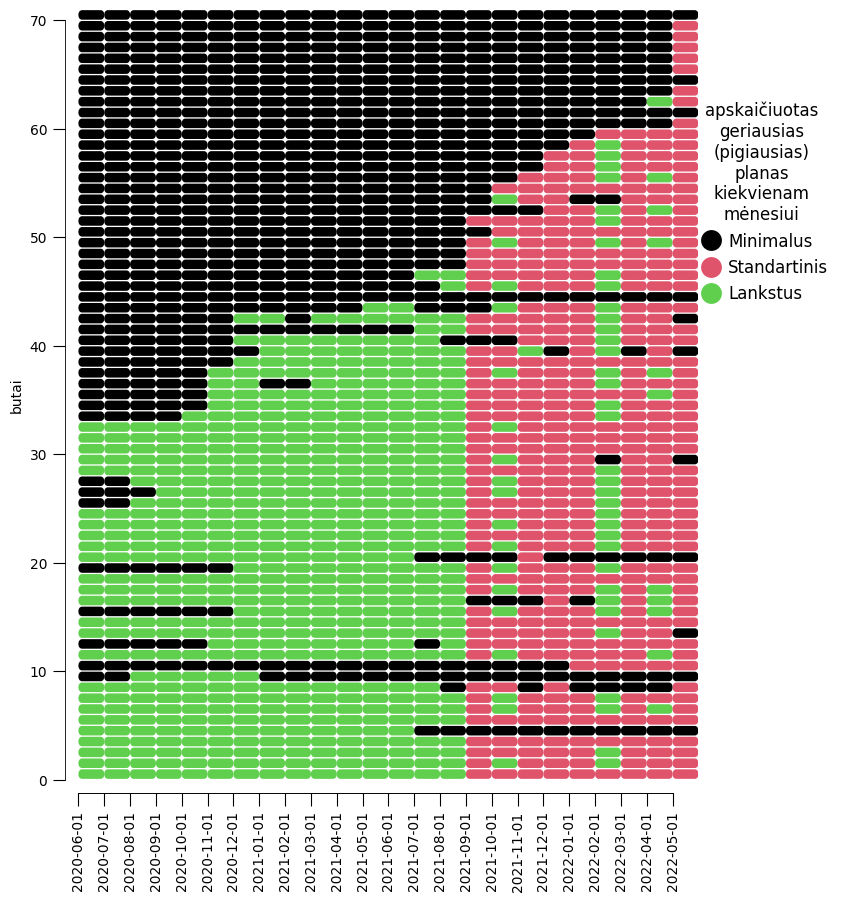

In [5]:
# Filter all apartments
df_butas = df[df['OBT_PAVADINIMAS'] == 'Butas']

selected_obj_numeris = df_butas['OBJ_NUMERIS'].unique()  # Get unique OBJ_NUMERIS list

# Compute the monthly consumption
monthly_usage = (
    df_butas
    .groupby(['OBJ_NUMERIS', 'Metai', 'Mėnuo'])['P+']
    .sum()
    .reset_index(name='Mėnesio_Suvartojimas')
)

# Define the range of months from June 2020 to May 2022
all_dates = pd.date_range(start="2020-06-01", end="2022-05-31", freq="MS")

# Create a Dataframe of all combinations of OBJ_NUMERIS and dates
all_combinations_df = pd.MultiIndex.from_product(
    [selected_obj_numeris, all_dates],
    names=["OBJ_NUMERIS", "Data"]
).to_frame(index=False)

# Extract Year and Month for easier merging
all_combinations_df["Metai"] = all_combinations_df["Data"].dt.year
all_combinations_df["Mėnuo"] = all_combinations_df["Data"].dt.month
# all_combinations_df.drop(columns=["Data"], inplace=True)

# Merge with existing monthly_usage Dataframe to find missing rows
merged_df = all_combinations_df.merge(
    monthly_usage,
    on=['OBJ_NUMERIS', 'Metai', 'Mėnuo'],
    how="left"
)

# Fill missing Mėnesio_Suvartojimas with 0
merged_df["Mėnesio_Suvartojimas"] = merged_df["Mėnesio_Suvartojimas"].fillna(0)

# Update the original monthly_usage Dataframe
monthly_usage = merged_df
# Sort the Dataframe
monthly_usage = monthly_usage.sort_values(by=['OBJ_NUMERIS', 'Metai', 'Mėnuo']).reset_index(drop=True)


# Merge hourly usage with NordPool prices
merged_df = pd.merge(df, df_price, on='PL_T', how='left')

# Calculate hourly costs for "Lankstus" plan
merged_df['Hourly_Cost'] = merged_df['P+'] * (0.08 + merged_df['Nord Pool Lietuva'])

# # Extract month and year for aggregation
merged_df['Metai'] = merged_df['PL_T'].dt.year
merged_df['Mėnuo'] = merged_df['PL_T'].dt.month

# # Sum up costs per month for each object
lankstus_costs = merged_df.groupby(['OBJ_NUMERIS', 'Metai', 'Mėnuo'])['Hourly_Cost'].sum().reset_index()
lankstus_costs.rename(columns={'Hourly_Cost': 'Viso_Kaina_Lankstus'}, inplace=True)

lankstus_costs['Viso_Kaina_Lankstus'] = lankstus_costs['Viso_Kaina_Lankstus'] + 3  # Add fixed price

# Add costs for Minimalus and Standartinis plans as new columns
monthly_usage['Minimalios_Kainos'] = monthly_usage['Mėnesio_Suvartojimas'] * 0.22 + 1
monthly_usage['Standartinės_Kainos'] = monthly_usage['Mėnesio_Suvartojimas'] * 0.2 + 2

# Add Lankstus cost by merging with the lankstus_costs Dataframe
monthly_usage = monthly_usage.merge(
    lankstus_costs[['OBJ_NUMERIS', 'Metai', 'Mėnuo', 'Viso_Kaina_Lankstus']],
    on=['OBJ_NUMERIS', 'Metai', 'Mėnuo'],
    how='left'
)

# Fill missing costs with 3
monthly_usage['Viso_Kaina_Lankstus'] = monthly_usage['Viso_Kaina_Lankstus'].fillna(3)

# Rename Lankstus column for consistency
monthly_usage.rename(columns={'Viso_Kaina_Lankstus': 'Lanksčios_Kainos'}, inplace=True)

# Compute the best plan for each row
def find_best_plan(row):
    costs = {
        'Minimalus': row['Minimalios_Kainos'],
        'Standartinis': row['Standartinės_Kainos'],
        'Lankstus': row['Lanksčios_Kainos']
    }
    # Find the plan with the minimum cost
    best_plan = min(costs, key=costs.get)
    return best_plan

# Apply the function to determine the best plan
monthly_usage['Geriausias_Planas'] = monthly_usage.apply(find_best_plan, axis=1)

# Sort the Dataframe
monthly_usage = monthly_usage.sort_values(by=['OBJ_NUMERIS', 'Metai', 'Mėnuo']).reset_index(drop=True)


np.random.seed(6)  # Set seed for reproducibility
selected_71_obj_numeris = np.random.choice(selected_obj_numeris, size=71, replace=False)

# Filter Dataframe to 71 apartments
monthly_usage_filtered = monthly_usage[monthly_usage['OBJ_NUMERIS']
                                       .isin(selected_71_obj_numeris)].reset_index(drop=True)


# Figure and axis setup for visualization
fig, ax = plt.subplots(figsize=(8, 10))

colors = {
    'Minimalus' : 'black', 
    'Standartinis' : '#df536b', # Pink colour
    'Lankstus' : '#60cf4e' # Green colour
    }
labels = ['Minimalus', 'Standartinis', 'Lankstus']

bars = []
for idx, row in monthly_usage_filtered.iterrows():

    # Retrieve the best plan from Dataframe
    best_plan = row['Geriausias_Planas']
    
    # Add the bar to the plot
    bar = ax.barh(idx // 24 + 0.5, 1, left=idx % 24, color=colors[best_plan])
    bars.append(bar[0])


# Modify bars to add rounded corners
for bar in bars:
    bb = bar.get_bbox()  # Get the bounding box of the patch
    color = bar.get_facecolor()  # Get the color of the bar
    
    # Create a rounded rectangle to replace the original bar
    rounded_patch = FancyBboxPatch(
        (bb.xmin, bb.ymin), 
        abs(bb.width), abs(bb.height),
        boxstyle="round,pad=0.01,rounding_size=0.15",  # Customize rounding size
        ec="none", fc=color,
        mutation_aspect=4
    )
    bar.remove()  # Remove the old rectangle
    ax.add_patch(rounded_patch)  # Add the new rounded rectangle

# Labeling and customization
ax.spines['bottom'].set_position(('outward', 10)) # Shift x axis outward
ax.spines['left'].set_position(('outward', 10)) #Shift y axis outward
ax.spines['top'].set_visible(False) # Hide axes
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0,24) # Set x and y limits
ax.set_ylim(0, 71)

# Set x and y ticks
ax.set_yticks(range(0, len(monthly_usage_filtered['OBJ_NUMERIS'].unique()), 10))
ax.set_xticks(np.arange(len(all_dates)))
ax.set_xticklabels(all_dates.strftime('%Y-%m-%d'), rotation=90)
ax.tick_params(axis='both', length=9, color='black')

# Replot y axis
ax.plot([-0.52, -0.52], [0, 70], color='black', lw=0.6,
        transform=ax.transData, clip_on=False)

# Replot x axis
ax.plot([0, 23], [-1.25, -1.25], color='black', lw=0.7,
        transform=ax.transData, clip_on=False)

# Add legend with wrapped title
wrapped_title = fill("apskaičiuotas geriausias (pigiausias) planas kiekvienam mėnesiui", width=15)

legend_labels = [
    plt.Line2D([0], [0], markerfacecolor=colors[i], color="none", marker='o', markeredgewidth=0)
    for i in ('Minimalus', 'Standartinis', 'Lankstus')
]

# Create the legend
legend = ax.legend(
    legend_labels, 
    [i for i in labels], 
    title=wrapped_title, loc="center left", 
    bbox_to_anchor=(0.97, 0.75), markerscale=2.5, handletextpad=0, framealpha=0,
    title_fontsize='12', fontsize='12'
)
# Center-align title horizontally
legend_title_obj = legend.get_title()
legend_title_obj.set_ha('center')

ax.set_ylabel("butai") # Set y label

ax.grid(False) # Hide grid
plt.show()


In [6]:
# Find which plans works best for which objects
def best_plans(monthly_usage):
    results = {}
    plans = ['Minimalus', 'Lankstus']
    
    # Loop through each plan
    for plan in plans:
        plan_counts = (
            monthly_usage[monthly_usage['Geriausias_Planas'] == plan]
            .groupby('OBJ_NUMERIS')
            .size()
            .reset_index(name=f'{plan}_Count')
        )
        
        max_duration = plan_counts[f'{plan}_Count'].max() # Count score
        longest_objects = plan_counts[plan_counts[f'{plan}_Count'] == max_duration]
        obj_list = longest_objects['OBJ_NUMERIS'].tolist() # Turn into list
        obj_list_string = ", ".join(map(str, obj_list)) # Join as string
        
        # Wrap the long string with textwrap.fill for better display
        wrapped_obj_list = fill(obj_list_string, width=80)  # Wrap at 80 characters
        
        results[plan] = {
            "Objects": wrapped_obj_list,
            "Months": max_duration
        }

    return results

# Call the method and display results
longest_duration_results = best_plans(monthly_usage)

for plan, details in longest_duration_results.items():
    print(f"Planas: {plan}")
    print(f"Ilgiausia trukmė (mėnesiai): {details['Months']}")
    print("Objektai:")
    print(details["Objects"])
    print("-" * 40)


Planas: Minimalus
Ilgiausia trukmė (mėnesiai): 24
Objektai:
569298, 12626492, 13208836, 18503206, 22155146, 22165128, 22170646, 23519018,
25065824, 25066010, 26055966, 26304392, 26335984, 27086572, 27126846, 27248058,
27569224, 27582560, 27602496, 27654782, 28016136, 28017810, 28066186, 28316554,
28389166
----------------------------------------
Planas: Lankstus
Ilgiausia trukmė (mėnesiai): 18
Objektai:
187040, 567918, 804102
----------------------------------------
